In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import tensorflow as tf
from nltk.stem import SnowballStemmer
from collections import Counter
from textblob import Word 
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import contractions
from nltk.corpus import stopwords
from nltk.corpus import reuters
from nltk.corpus import brown
from nltk.corpus import gutenberg
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud,ImageColorGenerator
import plotly.express as px
import re
import seaborn as sns
from textattack.augmentation import EasyDataAugmenter, EmbeddingAugmenter

2024-03-14 03:45:19.175561: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-14 03:45:19.299655: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-14 03:45:19.749585: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-03-14 03:45:19.749652: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

### **Load data and analyse stats**


In [2]:
dataset = pd.read_csv("train.csv")
print('Total number of sentences', len(dataset['Text']))
dataset['Verdict'].value_counts()

Total number of sentences 22501


-1    14685
 1     5413
 0     2403
Name: Verdict, dtype: int64

data distribution

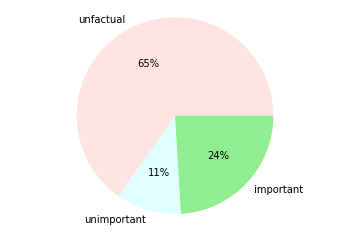

In [3]:
labels=['unfactual', 'unimportant', 'important']
colors = ['mistyrose','lightcyan','lightgreen']
sizes=[dataset['Verdict'].value_counts()[-1],
     dataset['Verdict'].value_counts()[0],
     dataset['Verdict'].value_counts()[1]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors,autopct='%1.0f%%')
ax1.axis('equal')
plt.show() # imbalance 65:24:11

## Split and observer data distribution

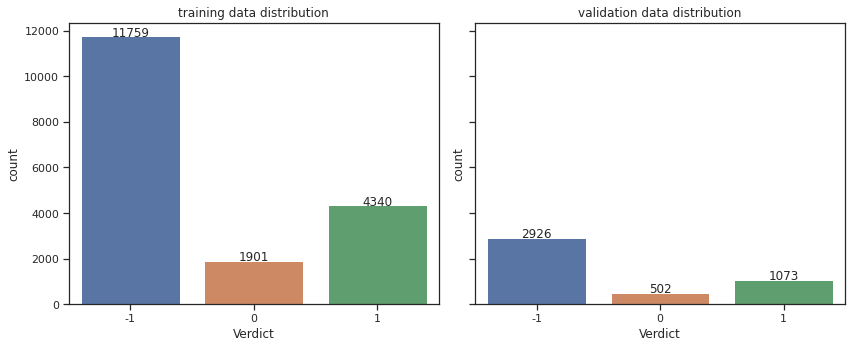

In [4]:
train_texts, val_texts, train_labels, val_labels = train_test_split(dataset["Text"], dataset["Verdict"], test_size = 0.2, random_state = 42)    
train_data = pd.DataFrame({'Text': train_texts, 'Verdict': train_labels})
val_data = pd.DataFrame({'Text': val_texts, 'Verdict': val_labels})

sns.set_theme(style="ticks")

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.countplot(ax=axes[0], x='Verdict', data=train_data).set_title('training data distribution')

value_counts_train = train_data['Verdict'].value_counts()
for i in axes[0].patches:
    height = i.get_height()
    x = i.get_x()
    axes[0].text(x + i.get_width() / 2., height + 0.1, f'{height}', ha="center")

sns.countplot(ax=axes[1], x='Verdict', data=val_data).set_title('validation data distribution')

value_counts_val = val_data['Verdict'].value_counts()
for i in axes[1].patches:
    height = i.get_height()
    x = i.get_x()
    axes[1].text(x + i.get_width() / 2., height + 0.1, f'{height}', ha="center")

plt.tight_layout()
plt.show() # sanity check: 11759+ 2926 = 14685

Notice that there are multiple conflicting data (same sentence with ddifferent lables)

In [5]:
grouped = train_data.groupby('Text')['Verdict'].agg(lambda x: set(x.unique()))
# print(grouped)
# texts = grouped[grouped.apply(len) == 1]
conflicting_train_texts = grouped[grouped.apply(len) > 1]
print(conflicting_train_texts) # conflicting sentence {labeled classes}
unconflicted_train_data = train_data.groupby('Text').filter(lambda x: len(x['Verdict'].unique()) == 1) #filter these classes out by setting uniqueness to 1
unconflicted_train_data['Verdict'].value_counts()

Text
Here we are with a government that's been dealing with a drug-running Panamanian dictator.     {0, 1}
I do not say that.                                                                            {1, -1}
That will not help us compete with China.                                                     {1, -1}
These appointments are for life.                                                              {0, -1}
We are better off than we were four years ago.                                                {1, -1}
We don't know who the rebels are.                                                             {1, -1}
Name: Verdict, dtype: object


-1    11754
 1     4335
 0     1899
Name: Verdict, dtype: int64

In [6]:
print(len(unconflicted_train_data['Text']))
print(len(unconflicted_train_data['Verdict']))

17988
17988


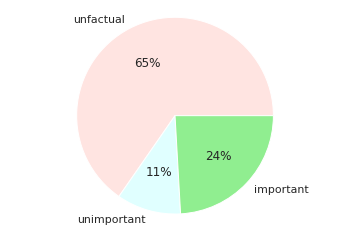

In [7]:
labels=['unfactual', 'unimportant', 'important']
colors = ['mistyrose','lightcyan','lightgreen']
sizes=[unconflicted_train_data['Verdict'].value_counts()[-1],
     unconflicted_train_data['Verdict'].value_counts()[0],
     unconflicted_train_data['Verdict'].value_counts()[1]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors,autopct='%1.0f%%')
ax1.axis('equal')
plt.show() # data distribution still remains the same

In [8]:
target_count = max(unconflicted_train_data['Verdict'].value_counts())

# augmented_df = pd.DataFrame(columns=['Cleaned Augmented', 'Verdict'])

def augmented_data(dataFrame, class_label, target_count, augmenter):

    class_df = dataFrame[dataFrame['Verdict'] == class_label]
    
    samples_to_generate = target_count - len(class_df) # num of samples to generate
    
    augmented_texts = []
    augmented_texts_labels = []

    while len(augmented_texts) < samples_to_generate:
        # Randomly select a sample to augment
        random_sentence = class_df.sample(1)['Text'].values[0]
        
        augmented_text = augmenter.augment(random_sentence)
        augmented_text = [text for text in augmented_text if text] # only accept non-empty augmentd strings
#         print('original setence that produce empty augmented string:', random_sentence)
        num_of_texts = len(augmented_text)
        if num_of_texts > 1:
            augmented_texts += augmented_text
        elif num_of_texts == 1:
            augmented_texts.append(augmented_text)
            
        augmented_texts_labels += [class_label] * num_of_texts
#         if len(augmented_texts) + len(class_df) >= target_count:
#             break
#         print(len(augmented_texts), samples_to_generate)
            
    return augmented_texts, augmented_texts_labels

In [9]:
# target_count = max(unconflicted_train_data['Verdict'].value_counts())
target_count = 20000 #raise the target count test with 25000, 30000
# print(augmented_data(unconflicted_data, 0, target_count, eda_augmenter))
eda = EasyDataAugmenter()
embedding = EmbeddingAugmenter() #takes too long ~ 3h lol

augmented_text_neg1, augmented_labels_neg1 = augmented_data(unconflicted_train_data,-1, target_count, eda)
augmented_text_0, augmented_labels_0 = augmented_data(unconflicted_train_data, 0, target_count, eda)
augmented_text_1, augmented_labels_1 = augmented_data(unconflicted_train_data, 1, target_count, eda)

[nltk_data] Downloading package omw-1.4 to /home/user/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [10]:
augmented_df_neg1 = pd.DataFrame(augmented_text_neg1, columns=['Text'])
augmented_df_0 = pd.DataFrame(augmented_text_0, columns=['Text'])
augmented_df_1 = pd.DataFrame(augmented_text_1, columns=['Text'])

augmented_df_neg1['Verdict'] = -1
augmented_df_0['Verdict'] = 0
augmented_df_1['Verdict'] = 1

augmented_df_neg1['Augmented'] = 1
augmented_df_0['Augmented'] = 1
augmented_df_1['Augmented'] = 1

unconflicted_train_data = pd.concat([unconflicted_train_data, augmented_df_neg1], ignore_index=True)
unconflicted_train_data = pd.concat([unconflicted_train_data, augmented_df_0], ignore_index=True)
unconflicted_train_data = pd.concat([unconflicted_train_data, augmented_df_1], ignore_index=True)
print(unconflicted_train_data['Verdict'].value_counts())

 0    20003
-1    20001
 1    20000
Name: Verdict, dtype: int64


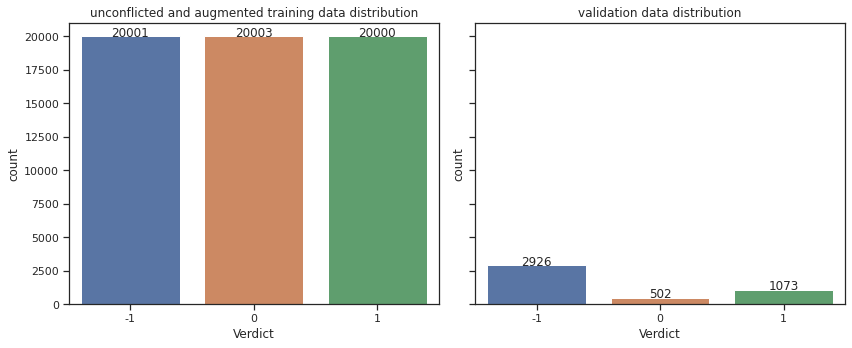

In [11]:
sns.set_theme(style="ticks")

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.countplot(ax=axes[0], x='Verdict', data=unconflicted_train_data).set_title('unconflicted and augmented training data distribution')

value_counts_train = unconflicted_train_data['Verdict'].value_counts()
for i in axes[0].patches:
    height = i.get_height()
    x = i.get_x()
    axes[0].text(x + i.get_width() / 2., height + 0.1, f'{height}', ha="center")

sns.countplot(ax=axes[1], x='Verdict', data=val_data).set_title('validation data distribution')

value_counts_val = val_data['Verdict'].value_counts()
for i in axes[1].patches:
    height = i.get_height()
    x = i.get_x()
    axes[1].text(x + i.get_width() / 2., height + 0.1, f'{height}', ha="center")

plt.tight_layout()
plt.show()

take a look at some of the augmented data

In [12]:
unconflicted_train_data[unconflicted_train_data['Augmented'] == 1]

,Text,Verdict,Augmented
17988,"You see, think don't I the American people are...",-1,1.0
17989,"You see, I don't think the American people are...",-1,1.0
17990,"You see, one don't think the American people a...",-1,1.0
17991,"You see, I don't think the mass American peopl...",-1,1.0
17992,And my opponent was unwilling to support that ...,-1,1.0
...,...,...,...
59999,"And in Crawford, Texas, Jiang Zemin and I agre...",1,1.0
60000,"It typeface was a horrible situation, no one l...",1,1.0
60001,"the TV a horrible to, no one liked to see it o...",1,1.0
60002,"It was a horrible situation, no one liked to s...",1,1.0


In [13]:
# unconflicted_train_data.to_csv('unconflicted_train_augmented.csv', index=False) #so that idh to wait 30 min for data augmentation each time
# unconflicted_train_data = pd.read_csv("unconflicted_train_augmented.csv")
len(unconflicted_train_data['Text'])

60004


# **Preprocessing**

In [30]:
exclusive = False # some stopwords may affect sentiment of sentence which mgight affect it being factual or not
remove_stopwords = False
lemmatize = False
reduce_short_words = True

def preprocess(text):
    
    text = contractions.fix(text)
    
    cleaned_text = text.lower().strip().replace('\n', ' ').replace('\r', ' ') # replce all newlines or returns
    cleaned_text = re.sub(r'[^a-zA-Z\']', ' ', cleaned_text)
    cleaned_text = re.sub(r'[^\x00-\x7F]+', '', cleaned_text)
    
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(cleaned_text)
    
    exclusive_stopwords = [
        'why', 'some', 'are', 'through', 'you', 'he', 'have', 'myself', 'not', 'does', 'could', 'did', 
        'should', 'can', 'my', 'she', 'here', 'do', 'was', 'will', 'herself', 'might', 'no', 'must', 'won', 
        'had', 'would', 'himself'
    ]
    stop_words = set(stopwords.words('english'))

    if exclusive: # filters all stopwords except exclusive ones
        stop_words = [word for word in stop_words if word not in exclusive_stopwords]

    if remove_stopwords:
        tokens = [token for token in tokens if token not in stop_words]
#     print(filtered_tokens)

    if reduce_short_words:
        short_words = [word for word in tokens if len(word) >= 2] #remove words that have less than 2 char
    else:
        short_words = tokens
#     print(short_words)
    
    if lemmatize:
        lemmatized_text = [Word(word).lemmatize() for word in short_words]
    else:
        lemmatized_text = short_words

    return " ".join(lemmatized_text)

In [31]:
text = unconflicted_train_data['Text'][5542]
print("original text:", text)
print("preprocessed text:", preprocess(text))

original text: (Applause) I'd like to have that line-item veto for the president, because I think that would be extraordinarily helpful.
preprocessed text: applause would like to have that line item veto for the president because think that would be extraordinarily helpful


In [32]:
unconflicted_train_data['Cleaned'] = unconflicted_train_data['Text'].apply(lambda x: preprocess(x))
val_data['Cleaned'] = val_data['Text'].apply(lambda x: preprocess(x))
# dataset['Cleaned'] = dataset['Text'].apply(lambda x: preprocess(x))
unconflicted_train_data.head()

,Text,Verdict,Augmented,Cleaned
0,"Mr. Nixon misstates my figures constantly, whi...",-1,NaN,mr nixon misstates my figures constantly which...
1,I supported what we did in Kosovo.,1,NaN,supported what we did in kosovo
2,Well let me make one thing clear.,-1,NaN,well let me make one thing clear
3,I think the result of this debate indicates th...,-1,NaN,think the result of this debate indicates that...
4,"I would like everybody to end it, just get rid...",-1,NaN,would like everybody to end it just get rid of it


In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, f1_score, recall_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

final check for any empty data

In [34]:
for index, item in enumerate(unconflicted_train_data['Cleaned']):
    if not isinstance(item, str):
        print(f"Index: {index}, Type: {type(item)}, Value: {item}") #augmented data result in empty string
# a = ['']
# a = [text for text in a if text] # only accept non-empty string
# b = ['asd', 'sad', 'sad']
# b.append(a)
# b

In [35]:
len(unconflicted_train_data['Cleaned']) #11754 + 11754 + 11757

60004

## **Feature Extraction**

In [36]:
count_vect = CountVectorizer(ngram_range=(1, 2)) #empirical test with increase ngrams range       
transformer = TfidfTransformer(norm='l2', sublinear_tf = True)
X_train_counts = count_vect.fit_transform(unconflicted_train_data['Cleaned'])
X_train_tfidf = transformer.fit_transform(X_train_counts)
# print(X_train_tfidf)
X_val_counts = count_vect.transform(val_data['Cleaned'])
X_val_tfidf = transformer.transform(X_val_counts)
# print(X_val_tfidf)

y_train = unconflicted_train_data['Verdict']
y_val = val_data['Verdict'] 

print (X_train_tfidf.shape, X_val_tfidf.shape, y_train.shape, y_val.shape)

(60004, 177809) (4501, 177809) (60004,) (4501,)


# **Logistic Regression**

Accuracy: 0.7502777160630971
micro f1-score: 0.7502777160630972
              precision    recall  f1-score   support

          -1       0.88      0.82      0.85      2926
           0       0.40      0.45      0.42       502
           1       0.63      0.69      0.66      1073

    accuracy                           0.75      4501
   macro avg       0.63      0.66      0.64      4501
weighted avg       0.76      0.75      0.76      4501



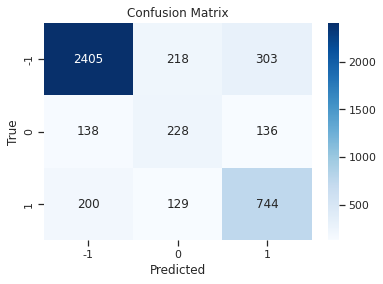

In [39]:
lr = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1, multi_class='multinomial')
# lr = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs', n_jobs=-1, C=1.0, penalty='l2')
lr.fit(X_train_tfidf, y_train)
y_pred = lr.predict(X_val_tfidf)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("micro f1-score:", f1_score(y_val, y_pred, average='micro'))
print(classification_report(y_val, y_pred))
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Naive Bayes

Accuracy: 0.7302821595201067
micro f1-score: 0.7502777160630972
              precision    recall  f1-score   support

          -1       0.88      0.79      0.83      2926
           0       0.39      0.45      0.41       502
           1       0.58      0.70      0.64      1073

    accuracy                           0.73      4501
   macro avg       0.62      0.65      0.63      4501
weighted avg       0.75      0.73      0.74      4501



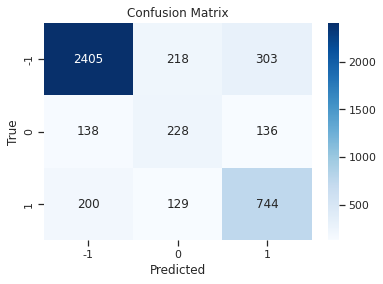

In [40]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(X_train_tfidf, y_train)
y_pred2 = mnb.predict(X_val_tfidf)
print("Accuracy:", accuracy_score(y_val,y_pred2))
print("micro f1-score:", f1_score(y_val, y_pred, average='micro'))
print(classification_report(y_val, y_pred2))
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Ensembling

Accuracy: 0.7724950011108642
micro f1-score: 0.7724950011108642
              precision    recall  f1-score   support

          -1       0.86      0.87      0.86      2926
           0       0.48      0.38      0.42       502
           1       0.66      0.68      0.67      1073

    accuracy                           0.77      4501
   macro avg       0.66      0.64      0.65      4501
weighted avg       0.77      0.77      0.77      4501



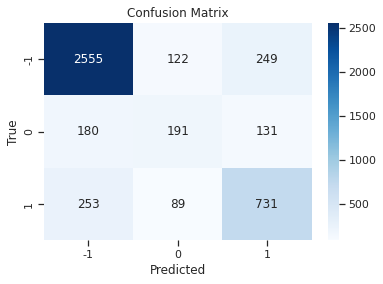

In [50]:
from sklearn.ensemble import VotingClassifier

mnb = MultinomialNB()
logReg = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
vc = VotingClassifier(estimators=[('Nauve Bayes', mnb),('Logistic Regression', logReg)], voting='soft', weights=[1,1])
vc.fit(X_train_tfidf, y_train)                                                 
y_pred_combined = ec.predict(X_val_tfidf)
print("Accuracy:", accuracy_score(y_val, y_pred_combined))
print("micro f1-score:", f1_score(y_val, y_pred_combined, average='micro'))
print(classification_report(y_val, y_pred_combined))
cm = confusion_matrix(y_val, y_pred_combined)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Submission to leaderboard

In [51]:
test = pd.read_csv('test.csv')
test['Cleaned'] = test['Text'].apply(lambda x: preprocess(x))

X_test_counts = count_vect.transform(test['Cleaned'])
X_test_tfidf = transformer.transform(X_test_counts)
result = ec.predict(X_test_tfidf)
print(len(list(result)))

1032


In [52]:
test['Verdict'] = pd.Series(result)
test.drop(columns=['Text'], inplace=True)
test.drop(columns=['Cleaned'], inplace=True)
test.to_csv('A0217019L.csv', index=False)

## try out the provided simple nn

In [21]:
import torch

# The default Tensor stores float values
X_train = torch.Tensor(X_train_tfidf.todense())
X_val = torch.Tensor(X_val_tfidf.todense())

# Our labels are integers, hence we use LongTensor
# (that's required, otherwise we would get an error later)

import numpy as np
from tensorflow.keras.utils import to_categorical

# Assuming y_train and y_val are Pandas Series or similar
y_train_mapped = torch.tensor([2 if label == -1 else label for label in y_train], dtype=torch.long)
y_val_mapped = torch.tensor([2 if label == -1 else label for label in y_val], dtype=torch.long)

print(X_train.shape, y_train_mapped.shape)
print(X_val.shape, y_val_mapped.shape)

torch.Size([75008, 178482]) torch.Size([75008])
torch.Size([4501, 178482]) torch.Size([4501])


In [22]:
from torch.utils.data import TensorDataset, DataLoader

dataset_train = TensorDataset(X_train, y_train_mapped)
dataset_val = TensorDataset(X_val, y_val_mapped)

batch_size = 64

loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

for X_batch, y_batch in loader_train:
    print("Shape of the input:", X_batch.shape)
    print("shape of the output:", y_batch.shape)
    break

Shape of the input: torch.Size([64, 178482])
shape of the output: torch.Size([64])


In [23]:
import torch.nn as nn
import torch.nn.functional as F

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
# class SimpleNet2(nn.Module):
    
#     def __init__(self, vocab_size):
#         super().__init__()
#         self.vocab_size = vocab_size
        
#         self.net = nn.Sequential(
#             nn.Linear(self.vocab_size, 4),
#             nn.ReLU(),
#             nn.Linear(4, 3),
#             nn.ReLU(),
#             nn.Linear(3, 3),
#             nn.ReLU(),
#             nn.Linear(3, 3),
#             nn.LogSoftmax(dim=1)
#         )
        
#     def forward(self, X):
#         log_probs = self.net(X)
#         return log_probs

class ModifiedSimpleNet2(nn.Module):
    def __init__(self, vocab_size):
        super(ModifiedSimpleNet2, self).__init__()
        self.vocab_size = vocab_size
        
        self.net = nn.Sequential(
            nn.Linear(self.vocab_size, 128), 
            nn.ReLU(),
            nn.Dropout(0.5), 
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5), 
            nn.BatchNorm1d(64), 
            nn.Linear(64, 32), 
            nn.ReLU(),
            nn.Dropout(0.5), 
            nn.BatchNorm1d(32),
            nn.Linear(32, 3),  
        )
        
    def forward(self, X):
        output = self.net(X)
        return output

In [24]:
from tqdm import tqdm
from sklearn import metrics

def evaluate(model, loader):

    model.eval()

    y_pred, y_test = [], []

    with tqdm(total=len(loader)) as pbar:
        
        for X_batch, y_batch in loader:

            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            log_probs = model(X_batch)                
            
            y_batch_pred = torch.argmax(log_probs, dim=1)

            y_test += list(y_batch.detach().cpu().numpy())
            y_pred += list(y_batch_pred.detach().cpu().numpy())

            pbar.update(1)

    model.train()            
            
    return metrics.f1_score(y_test, y_pred, average='micro')

In [25]:
classifier = ModifiedSimpleNet2(X_train.shape[1]).to(device)

print(classifier)
print(evaluate(classifier, loader_val))

ModifiedSimpleNet2(
  (net): Sequential(
    (0): Linear(in_features=178482, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.5, inplace=False)
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): ReLU()
    (10): Dropout(p=0.5, inplace=False)
    (11): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=32, out_features=3, bias=True)
  )
)


100%|██████████| 71/71 [00:15<00:00,  4.66it/s]

0.11153077093979116


In [26]:
def train(model, loader_train, loader_test, optimizer, criterion, num_epochs):

    losses, f1_train, f1_test = [], [], []
    
    model.train()

    for epoch in range(1, num_epochs+1):
        epoch_loss = 0.0

        with tqdm(total=len(loader_train)) as pbar:

            for X_batch, y_batch in loader_train:

                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                log_probs = classifier(X_batch)                

                loss = criterion(log_probs, y_batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

                pbar.update(1)
        
        losses.append(epoch_loss)
        
        f1_tr = evaluate(model, loader_train)
        f1_te = evaluate(model, loader_test)
        f1_train.append(f1_tr)
        f1_test.append(f1_te)

        print("Loss:\t{:.3f}, f1 train: {:.3f}, f1 test: {:.3f} (epoch {})".format(epoch_loss, f1_tr, f1_te, epoch))
     
    return losses, f1_train, f1_test        

In [27]:
criterion = nn.NLLLoss()

optimizer = torch.optim.Adam(classifier.parameters(), lr=0.0001)
num_epochs = 10

losses, f1_train, f1_test = train(classifier, loader_train, loader_val, optimizer, criterion, num_epochs)

100%|██████████| 71/71 [00:01<00:00, 52.55it/s]


Loss:	-1392.524, f1 train: 0.954, f1 test: 0.738 (epoch 1)


100%|██████████| 71/71 [00:01<00:00, 42.63it/s]


Loss:	-6339.625, f1 train: 0.985, f1 test: 0.736 (epoch 2)


100%|██████████| 71/71 [00:01<00:00, 46.37it/s]


Loss:	-12281.207, f1 train: 0.991, f1 test: 0.729 (epoch 3)


100%|██████████| 71/71 [00:02<00:00, 31.32it/s]


Loss:	-19083.356, f1 train: 0.993, f1 test: 0.731 (epoch 4)


100%|██████████| 71/71 [00:01<00:00, 52.06it/s]


Loss:	-26821.240, f1 train: 0.994, f1 test: 0.728 (epoch 5)


100%|██████████| 71/71 [00:01<00:00, 54.25it/s]


Loss:	-35454.199, f1 train: 0.994, f1 test: 0.734 (epoch 6)


100%|██████████| 71/71 [00:01<00:00, 47.74it/s]


Loss:	-45237.468, f1 train: 0.994, f1 test: 0.732 (epoch 7)


100%|██████████| 71/71 [00:01<00:00, 52.36it/s]


Loss:	-55753.989, f1 train: 0.995, f1 test: 0.739 (epoch 8)


100%|██████████| 71/71 [00:01<00:00, 44.01it/s]


Loss:	-67169.410, f1 train: 0.995, f1 test: 0.731 (epoch 9)


100%|██████████| 71/71 [00:02<00:00, 32.57it/s]

Loss:	-79677.657, f1 train: 0.995, f1 test: 0.739 (epoch 10)


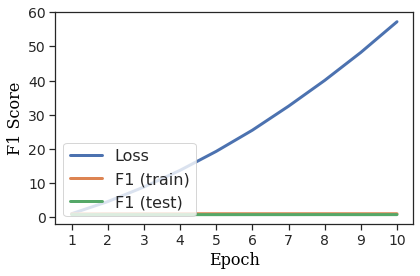

100%|██████████| 71/71 [00:31<00:00,  2.23it/s]

0.7393912463896912


In [28]:
x = list(range(1, len(losses)+1))

losses = np.asarray(losses)
losses = losses/np.max(losses)

plt.figure()

plt.plot(x, losses, lw=3)
plt.plot(x, f1_train, lw=3)
plt.plot(x, f1_test, lw=3)

font_axes = {'family':'serif','color':'black','size':16}

plt.gca().set_xticks(x)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Epoch", fontdict=font_axes)
plt.ylabel("F1 Score", fontdict=font_axes)
plt.legend(['Loss', 'F1 (train)', 'F1 (test)'], loc='lower left', fontsize=16)
plt.tight_layout()
plt.show()

print(evaluate(classifier, loader_val))

In [29]:
from tqdm import tqdm

def predict(model, loader):
    model.eval()  # Set the model to evaluation mode

    predictions = []

    with torch.no_grad(), tqdm(total=len(loader)) as pbar:
        for batch in loader:  
            X_batch = batch[0]  
            X_batch = X_batch.to(device)  

            log_probs = model(X_batch) 
            y_batch_pred = torch.argmax(log_probs, dim=1) 

            predictions.extend(y_batch_pred.detach().cpu().tolist())  
            pbar.update(1)

    return predictions


In [30]:
test_data = pd.read_csv('test.csv')

test_data['Cleaned'] = test_data['Text'].apply(lambda x: preprocess(x))
X_test_counts = count_vect.transform(test_data['Cleaned'])
X_test_tfidf = transformer.transform(X_test_counts)
X_test_tfidf.shape

(1032, 178482)

In [31]:
X_test = torch.Tensor(X_test_tfidf.todense())
dataset_test = TensorDataset(X_test)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [32]:
test_predictions = predict(classifier, loader_test)

100%|██████████| 17/17 [00:00<00:00, 50.07it/s]


In [33]:
result = torch.tensor([-1 if label == 2 else label for label in test_predictions], dtype=torch.long)
len(result)

1032

In [34]:
test_data['Verdict'] = pd.Series(result)
test_data.drop(columns=['Text'], inplace=True)
test_data.drop(columns=['Cleaned'], inplace=True)
test_data.to_csv('A0217019L.csv', index=False)

## Ablation notes ##
order of dataset preparation: 
1. split the dataset into train validation with 0.2 ratio
2. clean training data by removing conflicting texts (sentences which have 2 or more different classes)
3. augment the training data to dilute the dataset imbalance (we use eda for this)
4. preprocess both the training and validation
5. tf-idf training and validation data
6. fit the model and make predictions on the model

I have tried the following combination of preprocessing parameters:
- no removal of stopwords nor lemmatization, augment with eda, increased each dataset to 20000 each class, accuracy 0.75 f1: {-1: 0.85, 0: 0.44, 1: 0.67} (best so far) 0.82 on leaderboard
- no removal of stopwords nor lemmatization, augment with eda, accuracy: 0.76 f1: {-1: 0.85, 0: 0.41, -1: 0.66} 0.81 acc on leaderboard
- no preprocessing at all with eda augmentation 0.76 accuracy, leaderboard 0.80
- no removal of stopwords at all, lemmatize, augment with eda, accuracy 0.75, f1: {-1: 0.85, 0: 0.42, 1: 0.66} 0.80 acc on leaderboard
- removal of stopwords except exclusive stopwords, lemmatize, augment using eda, accuracy 0.74 f1: {-1: 0.84, 0: 0.36, 1: 0.64} 0.78 acc on leaderboard
- removal of all stopwords, lemmatize, augment using eda, accuracy 0.72 forgot f1 score, 0.74 on leaderboard
